# Data prep
Let's try using a very simple example - optimizing the location of just **1** hub, choosing between only **3** candidate locations. 

In [4]:
import pandas as pd
import momepy
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
import numpy as np
import shapely
import plotly.express as px
import time
import libpysal
from libpysal.weights import Queen, Rook, KNN, DistanceBand
import math
from scipy.optimize import minimize 
from geovoronoi import voronoi_regions_from_coords
pd.options.mode.chained_assignment = None  # default='warn'

# Read data (study area = AMS)
already prepared in `dataPrep.ipynb`: 
* `candiInfo` - gpd.geoDataFrame of candidate sites 
* `infoGrid` - gpd.geoDataFrame of wood supply and demand locations
* `costMatrix` - np.array of o-d matrix between candidate sites and s&d locations

provided by spsann: 
* `pointsArray` - np.array of proposed hubs

In [5]:
candiInfo = gpd.read_file('data/candiInfo_ams.shp')
infoGrid = gpd.read_file('data/infoGrid_ams.shp')
cost_matrix = np.load('data/costMatrix_ams.npy')

In [12]:
# make pointsArray 
pointsArray = candiInfo.sample(3)
pointsArray['x'] = pointsArray.geometry.x
pointsArray['y'] = pointsArray.geometry.y
pointsArray = pointsArray.reset_index()
pointsArray = pointsArray[['index', 'x', 'y']].to_numpy()

# Defining sub-functions

## assignHubsToGridCells

In [18]:
def assignHubsToGridCells(points, infoGrid): 
    # coords: array of coordinates for open hubs
    coords = np.array(points[['x', 'y']])

    # area_shape: polygon surrounding amsterdam (just make a square for now)
    minx, miny, maxx, maxy = infoGrid.total_bounds # get bounding box of infoGrid 
    area_shape = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx,miny)]).buffer(50)

    # make voronoi regions and pts
    region_polys, region_pts = voronoi_regions_from_coords(coords, area_shape)

    # match hubName in hubRegions to hubsOpen 
    hubRegions = gpd.GeoDataFrame({'hubName': region_polys.keys(), 'geometry': region_polys.values()})
    hubRegions = hubRegions.set_crs('EPSG:28992')
    hubRegions = gpd.sjoin(hubRegions, points)
    hubRegions = hubRegions[['hubName_right', 'geometry']]
    hubRegions.rename(columns={'hubName_right': 'hubName'}, inplace=True)

    # assign each infoGrid cell to the nearest open hub 
    def findHubName(x):
        # x = Point 
        hubName = hubRegions[hubRegions.geometry.contains(x)].iloc[0].hubName
        return hubName
    infoGrid_hubsAssigned = infoGrid.copy()
    infoGrid_hubsAssigned['hubName'] = infoGrid_hubsAssigned.geometry.map(lambda x: findHubName(x))
    infoGrid_hubsAssigned.hubName = infoGrid_hubsAssigned.hubName.map(lambda x: int(x))
    
    return infoGrid_hubsAssigned

## calculate CO2 reduction

In [25]:
def calcTotCo2Reduction(points, infoGrid_hubsAssigned): 
    
    # calc co2 reduction for each hub 
    def calcCo2Reduction(hubName, infoGrid_hubsAssigned):  
        # hubName = infoGrid.hubName.iloc[0] # 17 
        infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName] 
        # get info for grid cells covered by hub 
        co2Emissions = 50 # dummy number - tons of CO2eq emissions associated per kg of wood 
        totSupply = infoHub.totKgSupply.sum()
        totDemand = infoHub.totKgDemand.sum()
        matKgStored = totSupply # if totDemand > totSupply else totDemand
        co2Reduction = co2Emissions * matKgStored
        return co2Reduction
    
    # sum co2 reduction for all hubs 
    points['co2Reduction'] = points.hubName.map(lambda x: calcCo2Reduction(x, infoGrid_hubsAssigned))
    totCo2Reduction = points.co2Reduction.sum()
    return totCo2Reduction

## calculate storage cost

In [35]:
def calcTotStorageCost(points, infoGrid_hubsAssigned, candiInfo): 
        
    # calculate storage cost for one hub
    def calcStorageCost(hubName): 
        
        def calcStorCoef(kgPerM3, percLogistics, throughPut): 
            kg = kgPerM3 * 3 * (12/throughPut) # kg stored per m3 
            storCoef = (1+(percLogistics/100)) / kg 
            return storCoef

        infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName]
        
        # sqm required to store 1 kg of material for 1 year
        storageCoefLong = calcStorCoef(kgPerM3=600, percLogistics=30, throughPut=36)
        storageCoefShort = calcStorCoef(kgPerM3=600, percLogistics=30, throughPut=3)

        # calculate matKgStored 
        totSupply = infoHub.totKgSupply.sum()
        totDemand = infoHub.totKgDemand.sum()
        if totDemand > totSupply: 
            matKgStoredLong = 0 
            matKgStoredShort = totSupply 
        elif totSupply > totDemand: 
            matKgStoredLong = totSupply - totDemand 
            matKgStoredShort = totDemand

        # find land price
        landPrice = candiInfo.loc[hubName, 'pPerSqm'] 

        # calculate storage cost 
        storageCost = landPrice * (storageCoefLong * matKgStoredLong + storageCoefShort * matKgStoredShort)

        return storageCost
    
    # sum storage cost for all hubs
    points['storageCost'] = points.hubName.map(lambda x: calcStorageCost(x))
    totStorageCost = points.storageCost.sum()
    return totStorageCost

calcTotStorageCost(points, infoGrid_hubsAssigned, candiInfo)

0 7928500707.78084
0 17200267909.26659
0 3858426590.1777115


1387406153.420032

## calculate transportation cost

In [38]:
def calcTotTransportationCost(points, infoGrid_hubsAssigned, cost_matrix): 
    
    # calculate transportation cost for one hub
    def calcTransportationCost(hubName):
        infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName]
        
        # see data/transportation/tansCostPerKm_middelStukgoed.csv 
        euroPerKm = 1.55 # cost per km of transporting 12 tonnes of material 
        euroPerKmPerKg = 1.55 / 12 / 1000
        transPriceCoef = euroPerKmPerKg

        # find locations of demand and supply 
        hubDemand = infoHub[infoHub.totKgDemand > 0]
        hubSupply = infoHub[infoHub.totKgSupply > 0]

        # calc totDist and matKg for supply and demand 
        # cost_matrix[origin (clients), destination (facilities)]
        totDistSupply = cost_matrix[hubSupply.index, hubName].sum()
        matKgSupply = infoGrid_hubsAssigned.totKgSupply.sum() 
        # is currently just sum of totKgSupply, without taking into account each trip 
        totDistDemand = cost_matrix[hubDemand.index, hubName].sum()
        matKgDemand = infoGrid_hubsAssigned.totKgDemand.sum()

        # calc transportation cost 
        transportationCost = transPriceCoef * (totDistSupply * matKgSupply + totDistDemand * matKgDemand)
        transportationCost

        return transportationCost
    
    # sum transportation emissions all hubs
    points['transCost'] = points.hubName.map(lambda x: calcTransportationCost(x))
    totTransCost = points.transCost.sum()
    return totTransCost

## calculate transportation emissions

In [28]:
def calcTotTransportationEmissions(points, infoGrid_hubsAssigned, cost_matrix): 
    
    # calculate transportation emissions for one hub 
    def calcTransportationEmissions(hubName): 
        infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName]
        
        # incorporating transEmissionsCoef
        KgCo2PerKm = 0.5243 # kg CO2 emissions per km of 16t of material 
        TonsCo2PerKm = KgCo2PerKm / 1000 
        transEmissionsCoef = TonsCo2PerKm / 16000 

        # find locations of demand and supply 
        hubDemand = infoHub[infoHub.totKgDemand > 0]
        hubSupply = infoHub[infoHub.totKgSupply > 0]
        
        # calc totDist and matKg for supply and demand 
        # cost_matrix[origin (clients), destination (facilities)]
        totDistSupply = cost_matrix[hubSupply.index, hubName].sum()
        matKgSupply = infoGrid_hubsAssigned.totKgSupply.sum() 
        # is currently just sum of totKgSupply, without taking into account each trip 
        totDistDemand = cost_matrix[hubDemand.index, hubName].sum()
        matKgDemand = infoGrid_hubsAssigned.totKgDemand.sum()

        # calculate transportation emissions 
        transportationEmissions = transEmissionsCoef * (totDistSupply * matKgSupply + totDistDemand * matKgDemand)
        # TODO: better model this - see comments on calcTransportationCost

        return transportationEmissions

    # sum transportation emissions all hubs
    points['transEmissions'] = points.hubName.map(lambda x: calcTransportationEmissions(x))
    totTransEmissions = points.transEmissions.sum()
    return totTransEmissions

## calcCostEffectiveness 

In [13]:
def calcTotCostEffectiveness(pointsArray): 
    # make points gdf   
    points = gpd.GeoDataFrame(
            pointsArray, geometry=gpd.points_from_xy(pointsArray[:,1], pointsArray[:,2]), 
            crs='EPSG:28992'
        ).rename(columns={0: 'hubName', 1: 'x', 2: 'y'})
    points.hubName = points.hubName.map(lambda x: int(x))
    
    # assign hubs to grid cells 
    infoGrid_hubsAssigned = assignHubsToGridCells(points, infoGrid)
    
    # calculate sub-components
    totCo2Reduction = calcTotCo2Reduction(points, infoGrid_hubsAssigned)
    totStorageCost = calcTotStorageCost(points, infoGrid_hubsAssigned, candiInfo)
    totTransCost = calcTotTransportationCost(points, infoGrid_hubsAssigned, cost_matrix)
    totTransEmissions = calcTotTransportationEmissions(points, infoGrid_hubsAssigned, cost_matrix)
    
    # calculate cost effectiveness 
    costEffectiveness = (totStorageCost + totTransCost) / (totCo2Reduction - totTransEmissions)
    
    return costEffectiveness 

# Defining optimization functions

## optimize - enumeration

In [17]:
# optimize 
def optimize_enumeration(nHubCandidates, nHubsOpen): 
    # set constraints
    hubCandidates = setNHubCandidates(nHubCandidates)
    
    # create all possible solutions according to constraints 
    import itertools
    sols = list(itertools.product([0, 1], repeat=len(hubCandidates)))
    sols = [list(t) for t in sols if sum(t) == nHubsOpen]
    
    # calcluate cost effectiveness for each solution 
    solDict = {}
    for i,sol in enumerate(sols): 
        try: 
            solDict[i] = calcCostEffectiveness(sol, hubCandidates, infoGrid)
        except: 
            solDict[i] = 999999
    solsDf = pd.DataFrame(list(zip(solDict.keys(), solDict.values())), columns =['solNum', 'cost'])
    
    # find best solution 
    bestSolNum = int(solsDf.iloc[solsDf.cost.idxmin()].solNum)
    bestSol = sols[bestSolNum]
    bestSolGdf = hubCandidates.copy()
    bestSolGdf['open'] = bestSol
    solsDf['chosen'] = solsDf.solNum.map(lambda x: 1 if x == bestSolNum else 0)    
    
    return solsDf, bestSolGdf, sols

# test - it works! 
nHubCandidates = 5
nHubsOpen = 3
solsDf, bestSolGdf, sols = optimize_enumeration(nHubCandidates, nHubsOpen)

# Optimizing using different python packages
Options: 
* enumeration
* ask an expert
* spatial annealing in R 
* spatial annealing from scratch in Python (I can't find a damn package for spatial annealing in python)
* modifying cost matrix in spopt (instead of calculating just transportation costs, calculating cost/CO2 reduction instead)

## Enumeration
This is not feasible for a high number of candidate hubs, because the total number of possibilities is `2 ^ number of candidate hubs`. With just 100 hubs, the number of possible combinations is `2 ^ 100 = 1,267,650,600,228,229,401,496,703,205,376`

In [18]:
nHubCandidates = 5
nHubsOpen = 3
solsDf, bestSolGdf, sols = optimize_enumeration(nHubCandidates, nHubsOpen)

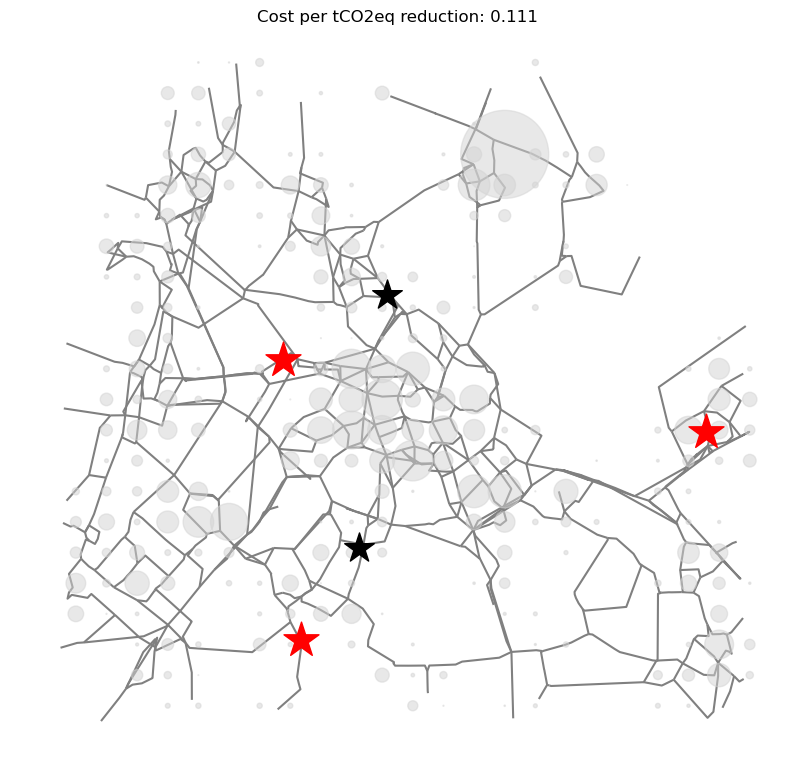

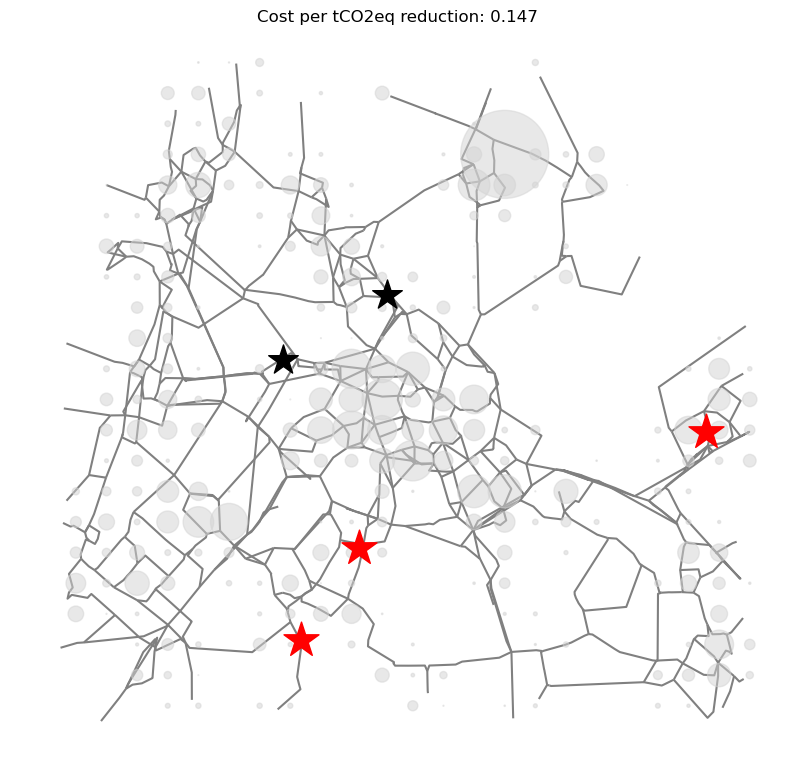

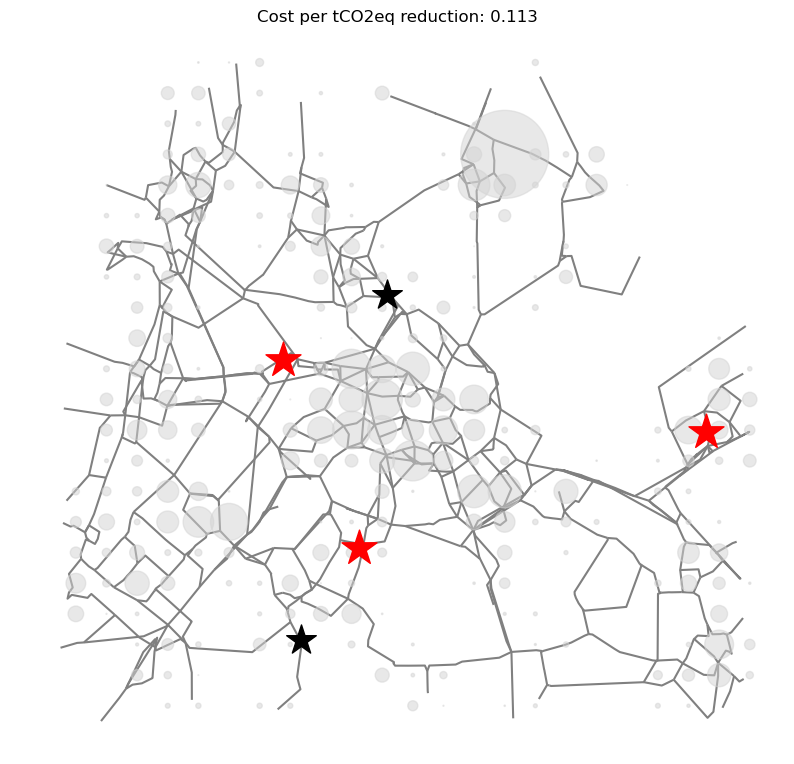

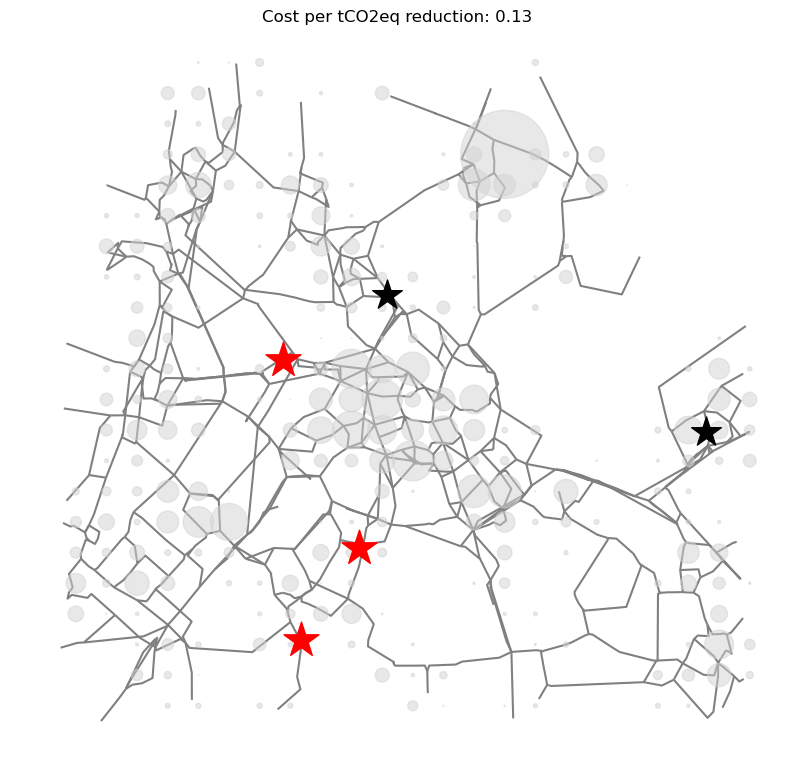

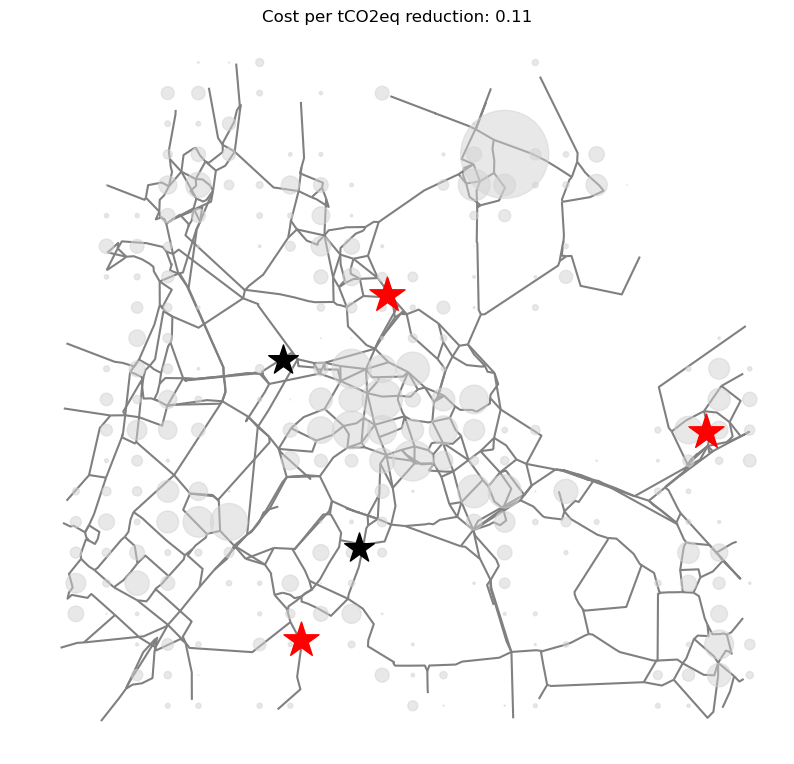

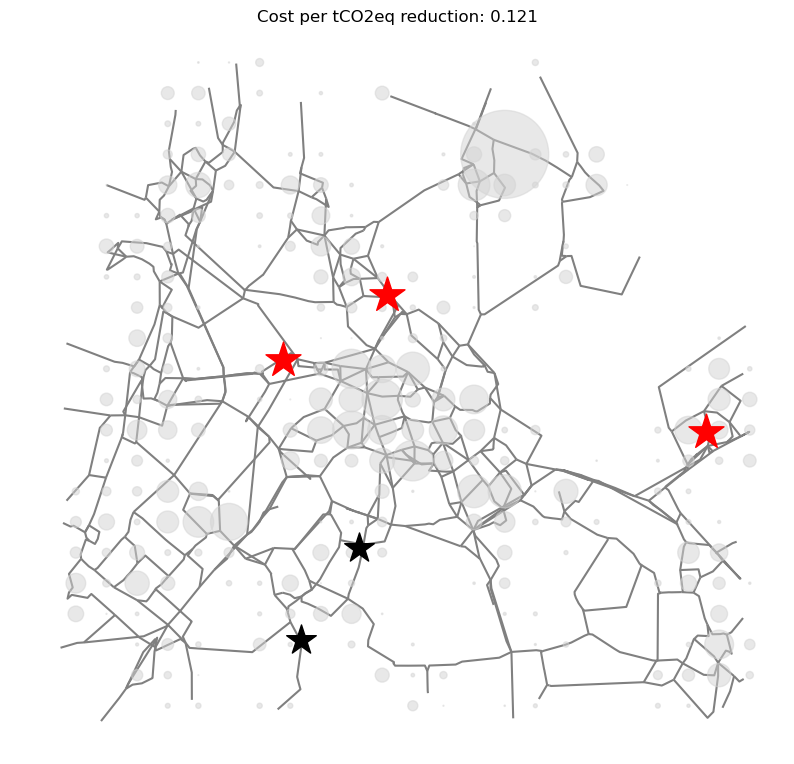

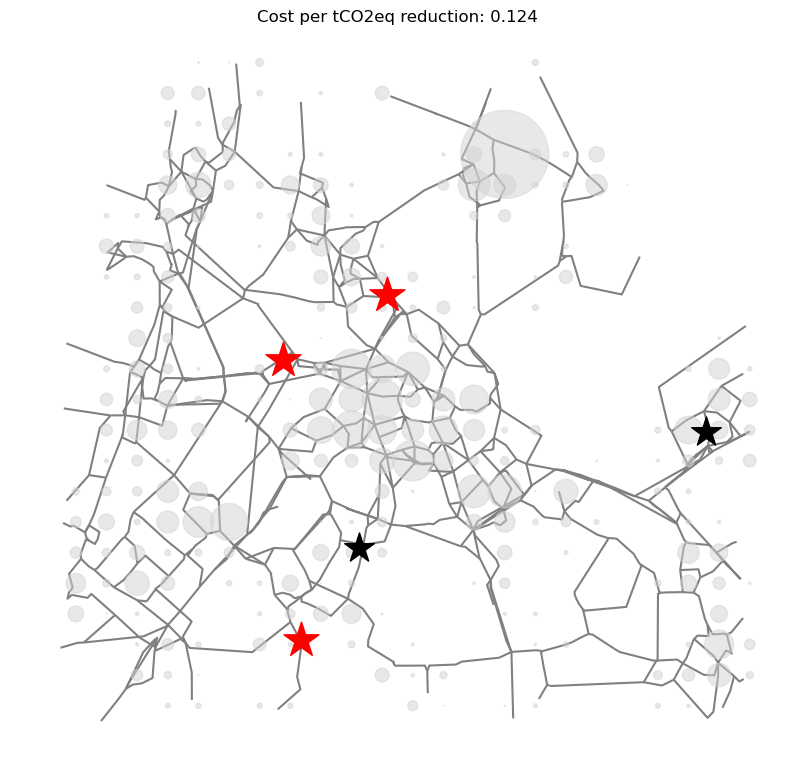

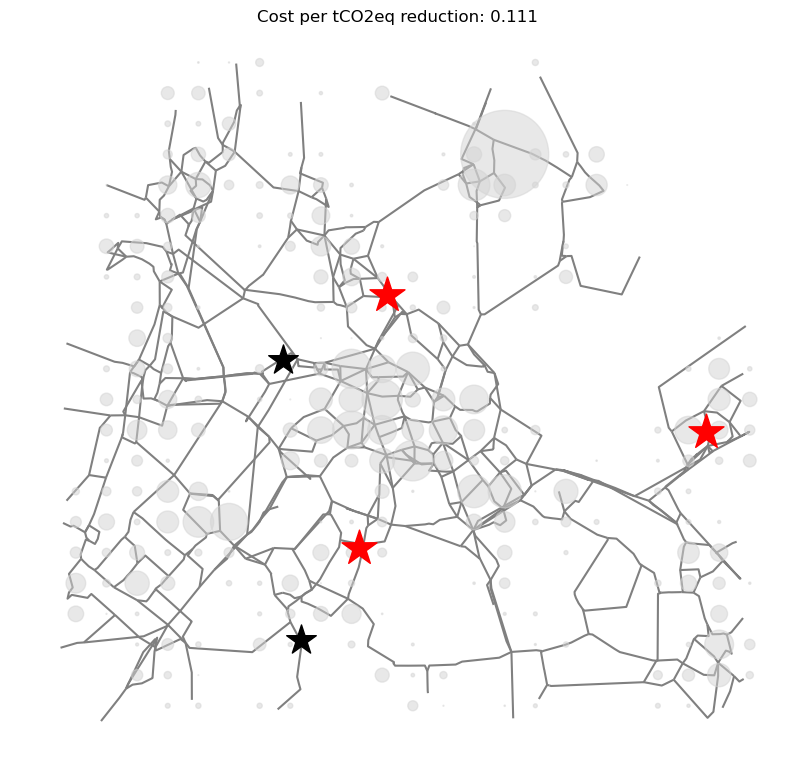

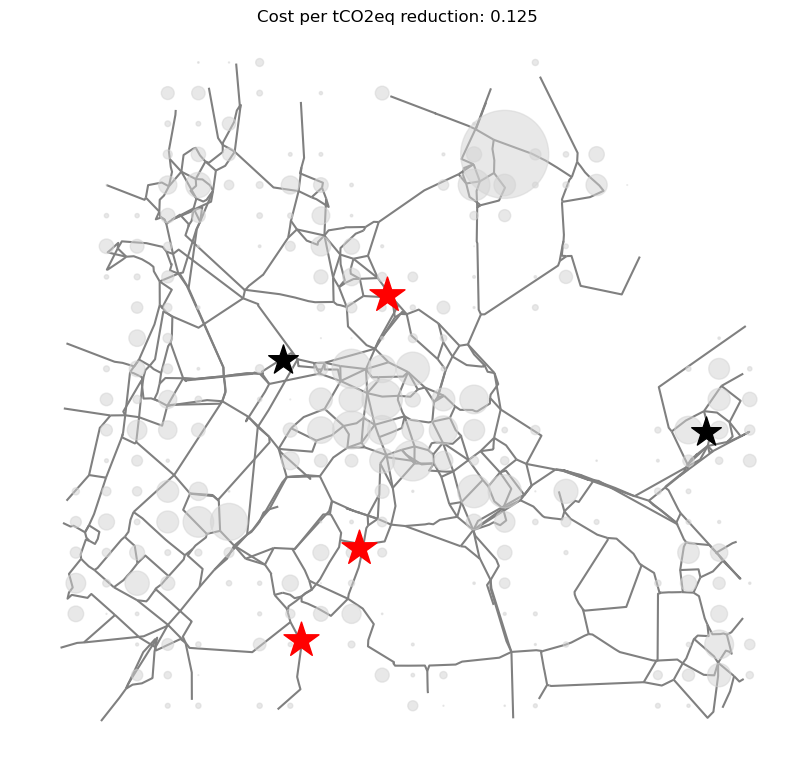

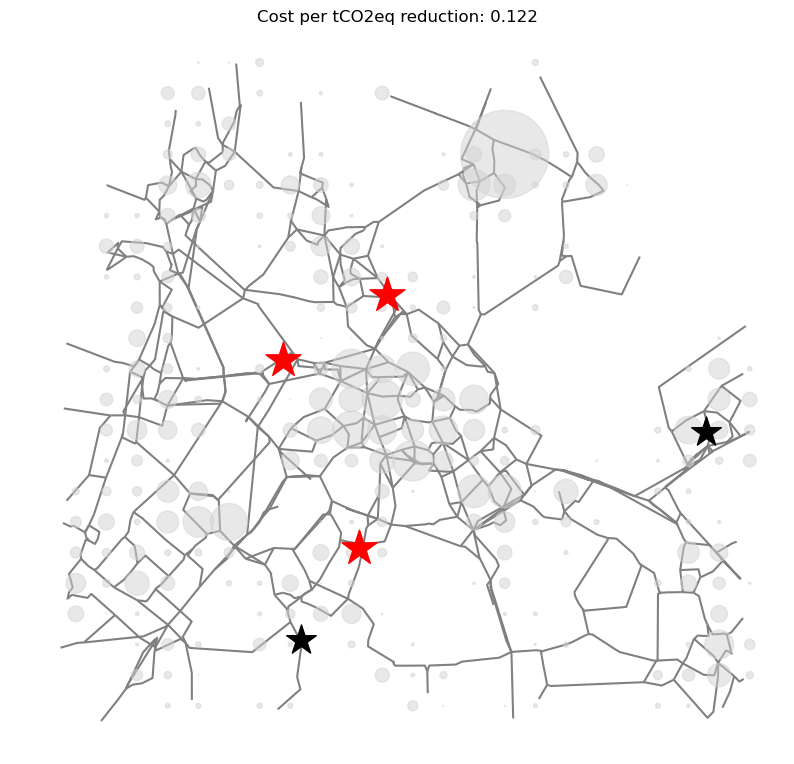

In [19]:
# plot solutions and their cost effectiveness value 
# for sol in sols: 
for i,sol in enumerate(sols): 
    # define open hubs and cost 
    hubCandidates = bestSolGdf.copy()
    hubCandidates.open = sol
    cost = solsDf.cost.iloc[i]
    
    # plot
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    infoGrid.plot(markersize=infoGrid.totKgSupply / 1000000, color='lightgrey', figsize=(8,8), alpha=0.5, ax=ax)
    streets.plot(ax=ax, color='grey', zorder=-1)
    hubCandidates.plot(ax=ax, color='black', marker='*', markersize=500)
    hubCandidates[hubCandidates.open ==1].plot(ax=ax, color='red', marker='*', markersize=700)
    ax.axis('off')
    ax.set_title('Cost per tCO2eq reduction: {}'.format(round(cost,3)))
    fig.savefig('results/gifs/optimization/enumeration_{}.png'.format(i))
    plt.show()

In [20]:
# make gif 
import imageio
images = []

for i,sol in enumerate(sols):
    images.append(imageio.imread('results/gifs/optimization/enumeration_{}.png'.format(i)))
imageio.mimsave('results/gifs/optimization/enumeration.gif', images, duration=1)

C:\Users\tpytsui\AppData\Local\Temp\ipykernel_16976\1205775924.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread('results/gifs/optimization/enumeration_{}.png'.format(i)))


In [21]:
sols[8]

[1, 1, 0, 1, 0]

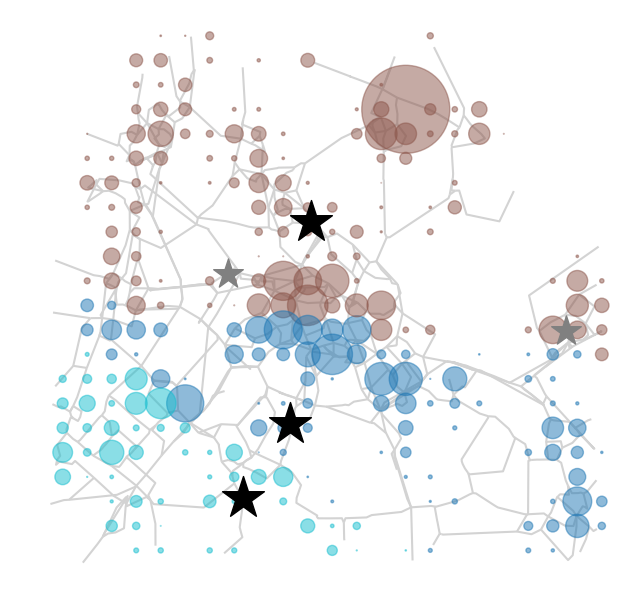

In [22]:
hubCandidates.open = sols[8]
hubsOpen = hubCandidates[hubCandidates.open == 1]
infoGrid_hubsAssigned = assignHubsToGridCells(hubsOpen, infoGrid, plot=False)

# plot best solution
fig, ax = plt.subplots(1,1,figsize=(8,8))
infoGrid_hubsAssigned.plot(markersize=infoGrid_hubsAssigned.totKgSupply / 1000000, column=infoGrid_hubsAssigned.hubName, alpha=0.5, ax=ax)
streets.plot(ax=ax, color='lightgrey', zorder=-1)
hubCandidates.plot(ax=ax, color='grey', marker='*', markersize=500)
hubCandidates[hubCandidates.open ==1].plot(ax=ax, color='black', marker='*', markersize=1000)
ax.axis('off')
plt.show()

## Using R package on spatial simulated annealing
* ssaOptim package [link](https://rdrr.io/cran/intamapInteractive/man/ssaOptim.html)
* using R packages in python [link](https://willfondrie.com/2022/01/how-to-use-r-packages-in-python/)

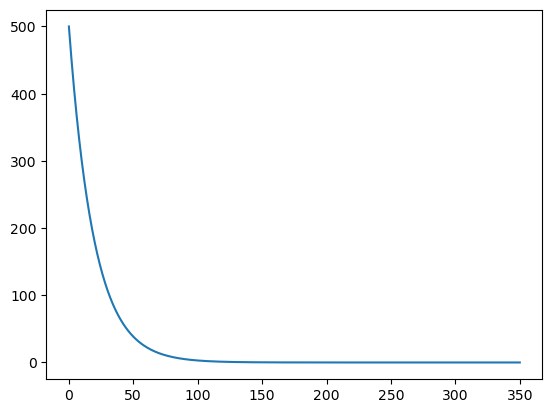

In [61]:
initialTemp = 500
tempDecrease = 0.95

tempList = []
tempList.append(initialTemp)

for i in range(350): 
    nextTemp = tempList[-1] * tempDecrease 
    tempList.append(nextTemp)
    
plt.plot(tempList)

In [ ]:
# These will let us use R packages:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

# Convert pandas.DataFrames to R dataframes automatically.
pandas2ri.activate()

## Simulated annealing in Python (not spatial)
Tutorials 
* https://machinelearningmastery.com/simulated-annealing-from-scratch-in-python/
* https://machinelearningmastery.com/dual-annealing-optimization-with-python/

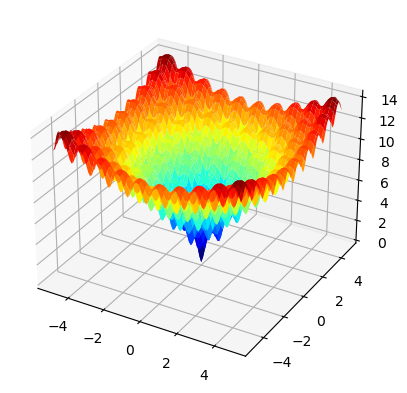

In [4]:
# ackley multimodal function
from numpy import arange
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi
from numpy import meshgrid
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
 
# objective function
def objective(x, y):
	return -20.0 * exp(-0.2 * sqrt(0.5 * (x**2 + y**2))) - exp(0.5 * (cos(2 * pi * x) + cos(2 * pi * y))) + e + 20
 
# define range for input
r_min, r_max = -5.0, 5.0
# sample input range uniformly at 0.1 increments
xaxis = arange(r_min, r_max, 0.1)
yaxis = arange(r_min, r_max, 0.1)
# create a mesh from the axis
x, y = meshgrid(xaxis, yaxis)
# compute targets
results = objective(x, y)
# create a surface plot with the jet color scheme
# figure = pyplot.figure()
# axis = figure.gca(projection='3d')
fig = pyplot.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x, y, results, cmap='jet')


# show the plot
pyplot.show()

In [7]:
# dual annealing global optimization for the ackley multimodal objective function
from scipy.optimize import dual_annealing
from numpy.random import rand
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi
 
# objective function
def objective(v):
	x, y = v
	return -20.0 * exp(-0.2 * sqrt(0.5 * (x**2 + y**2))) - exp(0.5 * (cos(2 * pi * x) + cos(2 * pi * y))) + e + 20
 
# define range for input
r_min, r_max = -5.0, 5.0
# define the bounds on the search
bounds = [[r_min, r_max], [r_min, r_max]]
# perform the dual annealing search
result = dual_annealing(objective, bounds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))


Status : ['Maximum number of iteration reached']
Total Evaluations: 4358
Solution: f([ 4.46262624e-10 -1.23177911e-09]) = 0.00000


In [8]:
bounds

[[-5.0, 5.0], [-5.0, 5.0]]

In [ ]:
# define the bounds on the search
bounds = [[r_min, r_max], [r_min, r_max]]
# perform the simulated annealing search
result = dual_annealing(objective, bounds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))


In [5]:
results

array([[12.64241118, 12.81640606, 13.28939488, ..., 13.72745259,
        13.28939488, 12.81640606],
       [12.81640606, 12.96636049, 13.38805943, ..., 13.77799374,
        13.38805943, 12.96636049],
       [13.28939488, 13.38805943, 13.69833859, ..., 13.98386843,
        13.69833859, 13.38805943],
       ...,
       [13.72745259, 13.77799374, 13.98386843, ..., 14.17155683,
        13.98386843, 13.77799374],
       [13.28939488, 13.38805943, 13.69833859, ..., 13.98386843,
        13.69833859, 13.38805943],
       [12.81640606, 12.96636049, 13.38805943, ..., 13.77799374,
        13.38805943, 12.96636049]])

# code dump

## old cost effectiveness code

In [ ]:
def assignHubsToGridCells(points, infoGrid): 
    timeAssignStart = time.time()    
    # coords: array of coordinates for open hubs
    coords = np.array(points[['x', 'y']])

    # area_shape: polygon surrounding amsterdam (just make a square for now)
    minx, miny, maxx, maxy = infoGrid.total_bounds # get bounding box of infoGrid 
    area_shape = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx,miny)]).buffer(50)
    timeAreaShape = time.time()
    
    # make voronoi regions and pts
    region_polys, region_pts = voronoi_regions_from_coords(coords, area_shape)
    timeVoronoi = time.time()

    # match hubName in hubRegions to hubsOpen 
    hubRegions = gpd.GeoDataFrame({'hubName': region_polys.keys(), 'geometry': region_polys.values()})
    hubRegions = hubRegions.set_crs('EPSG:28992')
    hubRegions = gpd.sjoin(hubRegions, points)
    hubRegions = hubRegions[['hubName_right', 'geometry']]
    hubRegions.rename(columns={'hubName_right': 'hubName'}, inplace=True)
    timeMatchHubName = time.time()

    # assign each infoGrid cell to the nearest open hub 
    def findHubName(x):
        # x = Point 
        hubName = hubRegions[hubRegions.geometry.contains(x)].iloc[0].hubName
        return hubName
    infoGrid_hubsAssigned = infoGrid.copy()
    infoGrid_hubsAssigned['hubName'] = infoGrid_hubsAssigned.geometry.map(lambda x: findHubName(x))
    infoGrid_hubsAssigned.hubName = infoGrid_hubsAssigned.hubName.map(lambda x: int(x))
    timeFindHubName = time.time()
    
    print('''
    times for assignHubsToGridCells
    area shape: {}
    voronoi: {}
    match hub name: {}
    find hub name: {}
    
    '''.format(
        timeAreaShape - timeAssignStart, 
        timeVoronoi - timeAreaShape, 
        timeMatchHubName - timeVoronoi, 
        timeFindHubName - timeMatchHubName
    ))
    
    return infoGrid_hubsAssigned

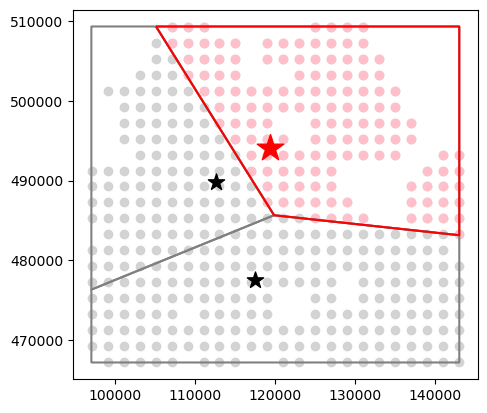

,index,geometry,totKgSupply,totKgDemand,hubName
0,0,POINT (135034.636 493256.830),0.000000e+00,0.000000e+00,1717
1,1,POINT (131034.636 493256.830),0.000000e+00,0.000000e+00,1717
2,2,POINT (131034.636 495256.830),8.944132e+07,9.931876e+07,1717
3,3,POINT (131034.636 497256.830),1.127251e+07,2.108463e+07,1717
4,4,POINT (133034.636 493256.830),0.000000e+00,0.000000e+00,1717


In [10]:
# assign open hubs to infoGrid using geovoronoi 
def assignHubsToGridCells(hubsOpen, infoGrid, plot=False): 
    from geovoronoi import voronoi_regions_from_coords

    # coords: array of coordinates for open hubs
    hubsOpen['lon'] = hubsOpen.geometry.x
    hubsOpen['lat'] = hubsOpen.geometry.y
    coords = np.array(hubsOpen[['lon', 'lat']])

    # area_shape: polygon surrounding amsterdam (just make a square for now)
    minx, miny, maxx, maxy = infoGrid.total_bounds # get bounding box of infoGrid 
    area_shape = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx,miny)]).buffer(50)

    # make voronoi regions and pts
    region_polys, region_pts = voronoi_regions_from_coords(coords, area_shape)

    # match hubName in hubRegions to hubsOpen 
    hubRegions = gpd.GeoDataFrame({'hubName': region_polys.keys(), 'geometry': region_polys.values()})
    hubRegions = hubRegions.set_crs('EPSG:28992')
    hubRegions = gpd.sjoin(hubRegions, hubsOpen)
    hubRegions = hubRegions[['hubName_right', 'geometry']]
    hubRegions.rename(columns={'hubName_right': 'hubName'}, inplace=True)

    # assign each infoGrid cell to the nearest open hub 
    def findHubName(x):
        # x = Point 
        hubName = hubRegions[hubRegions.geometry.contains(x)].iloc[0].hubName
        return hubName
    infoGrid_hubsAssigned = infoGrid.copy()
    infoGrid_hubsAssigned['hubName'] = infoGrid_hubsAssigned.geometry.map(lambda x: findHubName(x))
    
    # plot
    if plot: 
        hubName = infoGrid_hubsAssigned.hubName.iloc[0] 
        ax = infoGrid_hubsAssigned.plot(color='lightgrey')
        hubRegions.boundary.plot(ax=ax, color='grey')
        infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName].plot(ax=ax, color='pink')
        hubRegions[hubRegions.hubName == hubName].boundary.plot(ax=ax, color='red')
        hubsOpen.plot(ax=ax, marker='*', markersize=150, color='black')
        hubsOpen[hubsOpen.hubName == hubName].plot(ax=ax, marker='*', markersize=400, color='red')
        plt.show()
    
    return infoGrid_hubsAssigned

# test - it works!
hubsOpen = hubCandidates.copy() 
hubsOpen.open = [1,1,1,0,0]
hubsOpen = hubsOpen[hubsOpen.open == 1] # select open hubs according to sol 
infoGrid_hubsAssigned = assignHubsToGridCells(hubsOpen, infoGrid, plot=True)
infoGrid_hubsAssigned.head()

In [11]:
# calculate co2 reduction of one hub 
def calcCo2Reduction(hubName, infoGrid_hubsAssigned):  
    # hubName = infoGrid.hubName.iloc[0] # 17 
    infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName] # get info for grid cells covered by hub 
    co2Emissions = 5000000000 # dummy number - tons of CO2eq emissions associated per kg of wood 
    totSupply = infoHub.totKgSupply.sum()
    totDemand = infoHub.totKgDemand.sum()
    matKgStored = totSupply if totDemand > totSupply else totDemand
    co2Reduction = co2Emissions * matKgStored
    return co2Reduction

# test - it works!
calcCo2Reduction(hubCandidates.loc[0, 'hubName'], infoGrid_hubsAssigned)

5.928857900516084e+19

In [15]:
# calculate transportation emissions for one hub 
def calcTransportationEmissions(hubName, infoGrid_hubsAssigned): 
    infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName]
    transEmissionsCoef = 1 # dummy 
    
    # find locations of demand and supply 
    hubDemand = infoHub[infoHub.totKgDemand > 0]
    hubSupply = infoHub[infoHub.totKgSupply > 0]
    
    # calc totDist and matKg for supply and demand 
    totDistSupply = hubSupply.distance(hubCandidates[hubCandidates.hubName == hubName].geometry.iloc[0]).sum() 
    # TODO: is currently euclidean distance, need to take into account street network
    matKgSupply = infoGrid_hubsAssigned.totKgSupply.sum() # is currently just sum of totKgSupply, without taking into account each trip 
    totDistDemand = hubDemand.distance(hubCandidates[hubCandidates.hubName == hubName].geometry.iloc[0]).sum()
    matKgDemand = infoGrid_hubsAssigned.totKgDemand.sum()
       
    # calculate transportation emissions 
    transportationEmissions = transEmissionsCoef * (totDistSupply * matKgSupply + totDistDemand * matKgDemand)
    # TODO: better model this - see comments on calcTransportationCost
    
    return transportationEmissions

# test - it works!
hubName = hubCandidates.loc[0, 'hubName']
calcTransportationEmissions(hubName, infoGrid_hubsAssigned)

1.072472535058616e+17

In [14]:
# calculate transportation cost for one hub
def calcTransportationCost(hubName, infoGrid_hubsAssigned):
    infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName]
    transPriceCoef = 50 # dummy number - 
    
    # find locations of demand and supply 
    hubDemand = infoHub[infoHub.totKgDemand > 0]
    hubSupply = infoHub[infoHub.totKgSupply > 0]
    
    # calc totDist and matKg for supply and demand 
    totDistSupply = hubSupply.distance(hubCandidates[hubCandidates.hubName == hubName].geometry.iloc[0]).sum() 
    # TODO: is currently euclidean distance, need to take into account street network
    matKgSupply = infoGrid_hubsAssigned.totKgSupply.sum() # is currently just sum of totKgSupply, without taking into account each trip 
    totDistDemand = hubDemand.distance(hubCandidates[hubCandidates.hubName == hubName].geometry.iloc[0]).sum()
    matKgDemand = infoGrid_hubsAssigned.totKgDemand.sum()
    
    # calc transportation cost 
    transportationCost = transPriceCoef * (totDistSupply * matKgSupply + totDistDemand * matKgDemand)
    
    # TODO: better model this - the hub will not travel to all supply and demand locations...right? 
        # the hub would travel to all supply locations but not all demand locations. 
        # it would travel to all supply locations to collect materials to be stored. 
        # if demand > supply, it would only travel to demand locations that it can satisfy with material stock. 
        # if this is not modelled properly transport emissions will always greatly excees CO2 reduction (i think)
    
    return transportationCost

# test - it works!
hubName = hubCandidates.loc[0, 'hubName']
calcTransportationCost(hubName, infoGrid_hubsAssigned)

5.36236267529308e+18

In [12]:
# sensitivity analysis

# kgPerM3
kgPerM3Dict = {}
for i in np.linspace(kgPerM3 - kgPerM3*0.3, kgPerM3 + kgPerM3*0.3, num=10): 
    percLogistics = 30 
    throughPut = 12 
    kgPerM3Dict[i] = calcStorCoef(i, percLogistics, throughPut)
    
# percLogistics
percLogisticsDict = {}
for i in np.linspace(percLogistics - percLogistics*0.3, percLogistics + percLogistics*0.3, num=10): 
    throughPut = 12 
    kgPerM3 = 600
    percLogisticsDict[i] = calcStorCoef(i, throughPut, kgPerM3)
    
# throughPut
throughPutDict = {}
for i in np.linspace(throughPut - throughPut*0.3, throughPut + throughPut*0.3, num=10): 
    percLogistics = 30 
    kgPerM3 = 600
    throughPutDict[i] = calcStorCoef(kgPerM3, percLogistics, i)

sensPlot = pd.DataFrame({
    'kgPerM3': kgPerM3Dict.values(), 
    'percLogistics': percLogisticsDict.values(), 
    'throughPut': throughPutDict.values()
})
sensPlot = sensPlot.reset_index()
sensPlot = pd.melt(sensPlot, id_vars=['index'])
sensPlot

fig = px.line(sensPlot, x=sensPlot['index'], y='value', color='variable')
fig.show()

NameError: name 'kgPerM3' is not defined

In [13]:
# calculate storage cost for one hub 
def calcStorageCost(hubName, infoGrid_hubsAssigned, kgPerM3=600, percLogistics=30, throughPut=12): 
    
    def calcStorCoef(kgPerM3, percLogistics, throughPut): 
        kg = kgPerM3 * 3 * (12/throughPut) # kg stored per m3 
        storCoef = (1+(percLogistics/100)) / kg 
        return storCoef
    
    infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName]
    # sqm required to store 1 kg of material for 1 year
    storageCoef = calcStorCoef(kgPerM3, percLogistics, throughPut)
    
    # calculate matKgStored 
    totSupply = infoHub.totKgSupply.sum()
    totDemand = infoHub.totKgDemand.sum()
    matKgStored = totSupply if totDemand > totSupply else totDemand
    
    # find land price
    # pick housePrice in infoGrid cell closest to open hub
    landPrice = hubCandidates[hubCandidates.hubName == hubName].pricePerSqm.iloc[0] 
    
    # calculate storage cost 
    storageCost = landPrice * storageCoef * matKgStored

    # TODO: make differentiation between long and short term storage 
    return storageCost

# test - it works!
calcStorageCost(hubCandidates.loc[0, 'hubName'], infoGrid_hubsAssigned)

2096902907.8602667

In [16]:
# calculate cost effectiveness of one solution (with multiple open hubs)
def calcCostEffectiveness(sol, hubCandidates, infoGrid): 
    '''
    INPUT: 
    sol = [1,0,0,0,0] = list of open / close for hubs
    hubCandidates = gdf of candidate hubs 

    OUTPUT: 
    cost effectiveness of sol  
    '''

    # identify open (or 'chosen') facilities 
    hubsOpen = hubCandidates.copy() 
    hubsOpen.open = sol 
    hubsOpen = hubsOpen[hubsOpen.open == 1] # select open hubs according to sol 
    infoGrid_hubsAssigned = assignHubsToGridCells(hubsOpen, infoGrid, plot=False)
        
    # calculate costs and emissions for each open hub
    def calcComponents(hubName): 
        # calculate sub-functions 
        storageCost = calcStorageCost(hubName, infoGrid_hubsAssigned)
        transportationCost = calcTransportationCost(hubName, infoGrid_hubsAssigned)
        co2Reduction = calcCo2Reduction(hubName, infoGrid_hubsAssigned)
        transportationEmissions = calcTransportationEmissions(hubName, infoGrid_hubsAssigned)
        return storageCost, transportationCost, co2Reduction, transportationEmissions

    hubsOpen['subValues'] = hubsOpen.hubName.map(lambda x: calcComponents(x))
    for i,v in enumerate(['storageCost', 'transportationCost', 'co2Reduction', 'transportationEmissions']): 
        hubsOpen[v] = hubsOpen.subValues.map(lambda x: x[i])
    hubsOpen.drop(columns=['lon', 'lat', 'subValues'], inplace=True)

    # calculate cost effectiveness 
    storageCost = hubsOpen.storageCost.sum()
    transportationCost = hubsOpen.transportationCost.sum()
    co2Reduction = hubsOpen.co2Reduction.sum()
    transportationEmissions = hubsOpen.transportationEmissions.sum()

    costEffectiveness = (storageCost + transportationCost) / (co2Reduction - transportationEmissions)

    return costEffectiveness

# test - it works only when there are three or more open hubs
sol = [1,0,1,0,1]
calcCostEffectiveness(sol, hubCandidates, infoGrid)

0.12144392101832063

In [152]:
# this is what comes with the optimUSER module
pointsFromOptim = ibis.sample(3)
pointsFromOptim['x'] = pointsFromOptim.geometry.x
pointsFromOptim['y'] = pointsFromOptim.geometry.y
pointsFromOptim.rename(columns={'RIN_NUMMER': 'id'}, inplace=True)
pointsFromOptim = pointsFromOptim[['id', 'x', 'y']]
pointsFromOptim

,id,x,y
901,27201749,100729.218438,497591.277114
1234,170444,98971.835574,476111.107773
922,27201746,108323.284373,476964.792058


In [155]:
infoGrid.head()

,index,geometry,totKgSupply,totKgDemand
0,0,POINT (135034.636 493256.830),0.000000e+00,0.000000e+00
1,1,POINT (131034.636 493256.830),0.000000e+00,0.000000e+00
2,2,POINT (131034.636 495256.830),8.944132e+07,9.931876e+07
3,3,POINT (131034.636 497256.830),1.127251e+07,2.108463e+07
4,4,POINT (133034.636 493256.830),0.000000e+00,0.000000e+00


In [156]:
calcCostEffectiveness(pointsFromOptim, infoGrid)

0.1663813160085768

In [149]:
'''
inputs: 
pointsFromOptim - (df) of candidate sites generated by spsann, with columns ['id', 'x', 'y']
infoGrid - (gdf) grid of study area, with columns ['index', 'totKgSup', 'totKgDem', 'geometry']

processing: 
calculate cost effectiveness of placing circular hubs at 'points'

returns: 
cost effectiveness value - in euros/tCO2eq reduction
'''
# -------- COST EFFECTIVENESS CALCULATION ------ 
# calculate cost effectiveness of one solution (with multiple open hubs)
# TODO: change inputs to (points, infoGrid)
def calcCostEffectiveness(pointsFromOptim, infoGrid): 
    
    # -------- MAKE POINTS GDF -------- 
    points = pointsFromOptim.copy()
    points = gpd.GeoDataFrame(
        points, geometry=gpd.points_from_xy(points.x, points.y), 
        crs='EPSG:28992'
    )
    points = points.merge(ibis[['RIN_NUMMER', 'pricePerSqm']], left_on='id', right_on='RIN_NUMMER')
    points = points[['id', 'x', 'y', 'pricePerSqm', 'geometry']]
    points.rename(columns={'id': 'hubName'}, inplace=True)
    
    # --------- ASSIGN HUBS TO INFOGRID CELLS --------- 
    
    # assign hubs to grid cells 
    def assignHubsToGridCells(points, infoGrid): 
        from geovoronoi import voronoi_regions_from_coords

        # coords: array of coordinates for open hubs
        points = gpd.GeoDataFrame(
            points, geometry=gpd.points_from_xy(points.x, points.y), 
            crs='EPSG:28992'
        )
        points = points.set_index('hubName')
        coords = np.array(points[['x', 'y']])

        # area_shape: polygon surrounding amsterdam (just make a square for now)
        minx, miny, maxx, maxy = infoGrid.total_bounds # get bounding box of infoGrid 
        area_shape = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx,miny)]).buffer(50)

        # make voronoi regions and pts
        region_polys, region_pts = voronoi_regions_from_coords(coords, area_shape)

        # match hubName in hubRegions to hubsOpen 
        hubRegions = gpd.GeoDataFrame({'hubName': region_polys.keys(), 'geometry': region_polys.values()})
        hubRegions = hubRegions.set_crs('EPSG:28992')
        hubRegions = gpd.sjoin(hubRegions, points)
        hubRegions = hubRegions[['index_right', 'geometry']]
        hubRegions.rename(columns={'index_right': 'hubName'}, inplace=True)

        # assign each infoGrid cell to the nearest open hub 
        def findHubName(x):
            # x = Point 
            hubName = hubRegions[hubRegions.geometry.contains(x)].iloc[0].hubName
            return hubName
        infoGrid_hubsAssigned = infoGrid.copy()
        infoGrid_hubsAssigned['hubName'] = infoGrid_hubsAssigned.geometry.map(lambda x: findHubName(x))

        return infoGrid_hubsAssigned

    infoGrid_hubsAssigned = assignHubsToGridCells(points, infoGrid)    
    
    # -------- FUNCTIONS FOR CALCULATING COST EFFECTIVENESS COMPONENTS --------- 

    # calculate CO2 reduction for one hub
    def calcCo2Reduction(hubName, infoGrid_hubsAssigned):  
        # hubName = infoGrid.hubName.iloc[0] # 17 
        infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName] 
        # get info for grid cells covered by hub 
        co2Emissions = 5000000000 # dummy number - tons of CO2eq emissions associated per kg of wood 
        totSupply = infoHub.totKgSupply.sum()
        totDemand = infoHub.totKgDemand.sum()
        matKgStored = totSupply if totDemand > totSupply else totDemand
        co2Reduction = co2Emissions * matKgStored
        return co2Reduction

    # calculate storage cost for one hub
    def calcStorageCost(hubName, infoGrid_hubsAssigned, points, kgPerM3=600, percLogistics=30, throughPut=12): 

        def calcStorCoef(kgPerM3, percLogistics, throughPut): 
            kg = kgPerM3 * 3 * (12/throughPut) # kg stored per m3 
            storCoef = (1+(percLogistics/100)) / kg 
            return storCoef

        infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName]
        # sqm required to store 1 kg of material for 1 year
        storageCoef = calcStorCoef(kgPerM3, percLogistics, throughPut)

        # calculate matKgStored 
        totSupply = infoHub.totKgSupply.sum()
        totDemand = infoHub.totKgDemand.sum()
        matKgStored = totSupply if totDemand > totSupply else totDemand

        # find land price
        # pick housePrice in infoGrid cell closest to open hub
        landPrice = points[points.hubName == hubName].pricePerSqm.iloc[0] 

        # calculate storage cost 
        storageCost = landPrice * storageCoef * matKgStored

        # TODO: make differentiation between long and short term storage 
        return storageCost

    # calculate transportation cost for one hub
    def calcTransportationCost(hubName, infoGrid_hubsAssigned, points):
        infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName]
        transPriceCoef = 50 # dummy number - 

        # find locations of demand and supply 
        hubDemand = infoHub[infoHub.totKgDemand > 0]
        hubSupply = infoHub[infoHub.totKgSupply > 0]

        # calc totDist and matKg for supply and demand 
        totDistSupply = hubSupply.distance(points[points.hubName == hubName].geometry.iloc[0]).sum() 
        # TODO: is currently euclidean distance, need to take into account street network
        matKgSupply = infoGrid_hubsAssigned.totKgSupply.sum() # is currently just sum of totKgSupply, without taking into account each trip 
        totDistDemand = hubDemand.distance(points[points.hubName == hubName].geometry.iloc[0]).sum()
        matKgDemand = infoGrid_hubsAssigned.totKgDemand.sum()

        # calc transportation cost 
        transportationCost = transPriceCoef * (totDistSupply * matKgSupply + totDistDemand * matKgDemand)

        # TODO: better model this - the hub will not travel to all supply and demand locations...right? 
            # the hub would travel to all supply locations but not all demand locations. 
            # it would travel to all supply locations to collect materials to be stored. 
            # if demand > supply, it would only travel to demand locations that it can satisfy with material stock. 
            # if this is not modelled properly transport emissions will always greatly excees CO2 reduction (i think)

        return transportationCost

    # calculate transportation emissions for one hub 
    def calcTransportationEmissions(hubName, infoGrid_hubsAssigned, points): 
        infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName]
        transEmissionsCoef = 1 # dummy 

        # find locations of demand and supply 
        hubDemand = infoHub[infoHub.totKgDemand > 0]
        hubSupply = infoHub[infoHub.totKgSupply > 0]

        # calc totDist and matKg for supply and demand 
        totDistSupply = hubSupply.distance(points[points.hubName == hubName].geometry.iloc[0]).sum() 
        # TODO: is currently euclidean distance, need to take into account street network
        matKgSupply = infoGrid_hubsAssigned.totKgSupply.sum() # is currently just sum of totKgSupply, without taking into account each trip 
        totDistDemand = hubDemand.distance(points[points.hubName == hubName].geometry.iloc[0]).sum()
        matKgDemand = infoGrid_hubsAssigned.totKgDemand.sum()

        # calculate transportation emissions 
        transportationEmissions = transEmissionsCoef * (totDistSupply * matKgSupply + totDistDemand * matKgDemand)
        # TODO: better model this - see comments on calcTransportationCost

        return transportationEmissions

    # ---------- COST EFFECTIVENESS CALCULATION -------- 
    # calculate costs and emissions for each open hub
    def calcComponents(hubName): 
        # calculate sub-functions 
        storageCost = calcStorageCost(hubName, infoGrid_hubsAssigned, points)
        transportationCost = calcTransportationCost(hubName, infoGrid_hubsAssigned, points)
        co2Reduction = calcCo2Reduction(hubName, infoGrid_hubsAssigned)
        transportationEmissions = calcTransportationEmissions(hubName, infoGrid_hubsAssigned, points)
        return storageCost, transportationCost, co2Reduction, transportationEmissions

    points['subValues'] = points.hubName.map(lambda x: calcComponents(x))
    for i,v in enumerate(['storageCost', 'transportationCost', 'co2Reduction', 'transportationEmissions']): 
        points[v] = points.subValues.map(lambda x: x[i])
    points.drop(columns=['subValues'], inplace=True)

    # calculate cost effectiveness 
    storageCost = points.storageCost.sum()
    transportationCost = points.transportationCost.sum()
    co2Reduction = points.co2Reduction.sum()
    transportationEmissions = points.transportationEmissions.sum()
    
    costEffectiveness = (storageCost + transportationCost) / (co2Reduction - transportationEmissions)

    return costEffectiveness

In [102]:
# make points suitable for analysis 
points = pointsOptim.copy()
points = gpd.GeoDataFrame(
    points, geometry=gpd.points_from_xy(points.x, points.y), 
    crs='EPSG:28992'
)
points = points.merge(ibis[['RIN_NUMMER', 'pricePerSqm']], left_on='id', right_on='RIN_NUMMER')
points = points[['id', 'x', 'y', 'pricePerSqm', 'geometry']]
points.rename(columns={'id': 'hubName'}, inplace=True)
points

,hubName,x,y,pricePerSqm,geometry
0,707011,138160.757143,467512.280585,318.223459,POINT (138160.757 467512.281)
1,27201715,111140.791267,477411.173428,276.731888,POINT (111140.791 477411.173)
2,3358,125442.675094,493069.375370,241.391825,POINT (125442.675 493069.375)


In [134]:
infoGrid_hubsAssigned = assignHubsToGridCells(points, infoGrid)

In [136]:
print(infoGrid_hubsAssigned.hubName.unique())
infoGrid_hubsAssigned.head()

['3358' '27201715' '707011']


,index,geometry,totKgSupply,totKgDemand,hubName
0,0,POINT (135034.636 493256.830),0.000000e+00,0.000000e+00,3358
1,1,POINT (131034.636 493256.830),0.000000e+00,0.000000e+00,3358
2,2,POINT (131034.636 495256.830),8.944132e+07,9.931876e+07,3358
3,3,POINT (131034.636 497256.830),1.127251e+07,2.108463e+07,3358
4,4,POINT (133034.636 493256.830),0.000000e+00,0.000000e+00,3358


In [118]:
# -------- FUNCTIONS FOR CALCULATING COST EFFECTIVENESS COMPONENTS --------- 

# calculate CO2 reduction for one hub
def calcCo2Reduction(hubName, infoGrid_hubsAssigned):  
    # hubName = infoGrid.hubName.iloc[0] # 17 
    infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName] 
    # get info for grid cells covered by hub 
    co2Emissions = 5000000000 # dummy number - tons of CO2eq emissions associated per kg of wood 
    totSupply = infoHub.totKgSupply.sum()
    totDemand = infoHub.totKgDemand.sum()
    matKgStored = totSupply if totDemand > totSupply else totDemand
    co2Reduction = co2Emissions * matKgStored
    return co2Reduction

# calculate storage cost for one hub
def calcStorageCost(hubName, infoGrid_hubsAssigned, points, kgPerM3=600, percLogistics=30, throughPut=12): 

    def calcStorCoef(kgPerM3, percLogistics, throughPut): 
        kg = kgPerM3 * 3 * (12/throughPut) # kg stored per m3 
        storCoef = (1+(percLogistics/100)) / kg 
        return storCoef

    infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName]
    # sqm required to store 1 kg of material for 1 year
    storageCoef = calcStorCoef(kgPerM3, percLogistics, throughPut)

    # calculate matKgStored 
    totSupply = infoHub.totKgSupply.sum()
    totDemand = infoHub.totKgDemand.sum()
    matKgStored = totSupply if totDemand > totSupply else totDemand

    # find land price
    # pick housePrice in infoGrid cell closest to open hub
    landPrice = points[points.hubName == hubName].pricePerSqm.iloc[0] 

    # calculate storage cost 
    storageCost = landPrice * storageCoef * matKgStored

    # TODO: make differentiation between long and short term storage 
    return storageCost

# calculate transportation cost for one hub
def calcTransportationCost(hubName, infoGrid_hubsAssigned, points):
    infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName]
    transPriceCoef = 50 # dummy number - 

    # find locations of demand and supply 
    hubDemand = infoHub[infoHub.totKgDemand > 0]
    hubSupply = infoHub[infoHub.totKgSupply > 0]

    # calc totDist and matKg for supply and demand 
    totDistSupply = hubSupply.distance(points[points.hubName == hubName].geometry.iloc[0]).sum() 
    # TODO: is currently euclidean distance, need to take into account street network
    matKgSupply = infoGrid_hubsAssigned.totKgSupply.sum() # is currently just sum of totKgSupply, without taking into account each trip 
    totDistDemand = hubDemand.distance(points[points.hubName == hubName].geometry.iloc[0]).sum()
    matKgDemand = infoGrid_hubsAssigned.totKgDemand.sum()

    # calc transportation cost 
    transportationCost = transPriceCoef * (totDistSupply * matKgSupply + totDistDemand * matKgDemand)

    # TODO: better model this - the hub will not travel to all supply and demand locations...right? 
        # the hub would travel to all supply locations but not all demand locations. 
        # it would travel to all supply locations to collect materials to be stored. 
        # if demand > supply, it would only travel to demand locations that it can satisfy with material stock. 
        # if this is not modelled properly transport emissions will always greatly excees CO2 reduction (i think)

    return transportationCost

# calculate transportation emissions for one hub 
def calcTransportationEmissions(hubName, infoGrid_hubsAssigned, points): 
    infoHub = infoGrid_hubsAssigned[infoGrid_hubsAssigned.hubName == hubName]
    transEmissionsCoef = 1 # dummy 

    # find locations of demand and supply 
    hubDemand = infoHub[infoHub.totKgDemand > 0]
    hubSupply = infoHub[infoHub.totKgSupply > 0]

    # calc totDist and matKg for supply and demand 
    totDistSupply = hubSupply.distance(points[points.hubName == hubName].geometry.iloc[0]).sum() 
    # TODO: is currently euclidean distance, need to take into account street network
    matKgSupply = infoGrid_hubsAssigned.totKgSupply.sum() # is currently just sum of totKgSupply, without taking into account each trip 
    totDistDemand = hubDemand.distance(points[points.hubName == hubName].geometry.iloc[0]).sum()
    matKgDemand = infoGrid_hubsAssigned.totKgDemand.sum()

    # calculate transportation emissions 
    transportationEmissions = transEmissionsCoef * (totDistSupply * matKgSupply + totDistDemand * matKgDemand)
    # TODO: better model this - see comments on calcTransportationCost

    return transportationEmissions

707011


array(['3358', '27201715', '707011'], dtype=object)

In [125]:
points.hubName[0]

'707011'

In [117]:
hubCandidates

,id,x,y,geometry
946,3358,125442.675094,493069.375370,POINT (125442.675 493069.375)
922,27201746,108323.284373,476964.792058,POINT (108323.284 476964.792)
925,1447,119512.204043,488153.956855,POINT (119512.204 488153.957)


In [112]:
points[points.hubName == '3358'].pricePerSqm.iloc[0]

241.39182485712388

In [145]:
# calculate costs and emissions for each open hub
def calcComponents(hubName): 
    # calculate sub-functions 
    storageCost = calcStorageCost(hubName, infoGrid_hubsAssigned, points)
    transportationCost = calcTransportationCost(hubName, infoGrid_hubsAssigned, points)
    co2Reduction = calcCo2Reduction(hubName, infoGrid_hubsAssigned)
    transportationEmissions = calcTransportationEmissions(hubName, infoGrid_hubsAssigned, points)
    return storageCost, transportationCost, co2Reduction, transportationEmissions

points['subValues'] = points.hubName.map(lambda x: calcComponents(x))
for i,v in enumerate(['storageCost', 'transportationCost', 'co2Reduction', 'transportationEmissions']): 
    points[v] = points.subValues.map(lambda x: x[i])
points.drop(columns=['subValues'], inplace=True)

In [146]:
points

,hubName,x,y,pricePerSqm,geometry,storageCost,transportationCost,co2Reduction,transportationEmissions
0,707011,138160.757143,467512.280585,318.223459,POINT (138160.757 467512.281),5.222439e+08,2.003697e+18,1.136162e+19,4.007395e+16
1,27201715,111140.791267,477411.173428,276.731888,POINT (111140.791 477411.173),1.741857e+09,6.210500e+18,4.357652e+19,1.242100e+17
2,3358,125442.675094,493069.375370,241.391825,POINT (125442.675 493069.375),3.138018e+09,8.605185e+18,8.999783e+19,1.721037e+17


In [148]:
# calculate cost effectiveness 
storageCost = points.storageCost.sum()
transportationCost = points.transportationCost.sum()
co2Reduction = points.co2Reduction.sum()
transportationEmissions = points.transportationEmissions.sum()

costEffectiveness = (storageCost + transportationCost) / (co2Reduction - transportationEmissions)
costEffectiveness

0.11631694436626477

In [142]:
points.subValues[0]

(522243867.56696707,
 2.0036974100440576e+18,
 1.136162141684643e+19,
 4.007394820088115e+16)

In [96]:
# assign hubs to grid cells 
def assignHubsToGridCells(points, infoGrid): 
    from geovoronoi import voronoi_regions_from_coords

    # coords: array of coordinates for open hubs
    points = gpd.GeoDataFrame(
        points, geometry=gpd.points_from_xy(points.x, points.y), 
        crs='EPSG:28992'
    )
    points = points.set_index('hubName')
    coords = np.array(points[['x', 'y']])

    # area_shape: polygon surrounding amsterdam (just make a square for now)
    minx, miny, maxx, maxy = infoGrid.total_bounds # get bounding box of infoGrid 
    area_shape = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx,miny)]).buffer(50)

    # make voronoi regions and pts
    region_polys, region_pts = voronoi_regions_from_coords(coords, area_shape)

    # match hubName in hubRegions to hubsOpen 
    hubRegions = gpd.GeoDataFrame({'hubName': region_polys.keys(), 'geometry': region_polys.values()})
    hubRegions = hubRegions.set_crs('EPSG:28992')
    hubRegions = gpd.sjoin(hubRegions, points)
    hubRegions = hubRegions[['index_right', 'geometry']]
    hubRegions.rename(columns={'index_right': 'hubName'}, inplace=True)

    # assign each infoGrid cell to the nearest open hub 
    def findHubName(x):
        # x = Point 
        hubName = hubRegions[hubRegions.geometry.contains(x)].iloc[0].hubName
        return hubName
    infoGrid_hubsAssigned = infoGrid.copy()
    infoGrid_hubsAssigned['hubName'] = infoGrid_hubsAssigned.geometry.map(lambda x: findHubName(x))

    return infoGrid_hubsAssigned

infoGrid_hubsAssigned = assignHubsToGridCells(points, infoGrid)

In [98]:
infoGrid_hubsAssigned.hubName.unique()

array(['1709', '1597', '27201165'], dtype=object)

In [84]:
points

,id,x,y,hubName
913,160008,113935.640894,486024.248380,160008
940,27201011,120407.708519,493360.370807,27201011
978,1601,112521.245252,477252.532653,1601


In [78]:
ibis[ibis.RIN_NUMMER.isin(list(points.id))]

,RIN_NUMMER,MAX_MILIEU,pricePerSqm,geometry
913,160008,3,257.195438,POINT (113935.641 486024.248)
940,27201011,3,244.853568,POINT (120407.709 493360.371)
978,1601,3,289.956851,POINT (112521.245 477252.533)


In [44]:
test = gpd.GeoDataFrame(
    hubCandidates, geometry=gpd.points_from_xy(hubCandidates.x, hubCandidates.y), 
    crs='EPSG:28992'
)

In [47]:
test

,id,x,y,geometry
946,3358,125442.675094,493069.375370,POINT (125442.675 493069.375)
922,27201746,108323.284373,476964.792058,POINT (108323.284 476964.792)
925,1447,119512.204043,488153.956855,POINT (119512.204 488153.957)


In [65]:
def assignHubsToGridCells(points, infoGrid): 
    from geovoronoi import voronoi_regions_from_coords

    # coords: array of coordinates for open hubs
    points = gpd.GeoDataFrame(
        points, geometry=gpd.points_from_xy(points.x, points.y), 
        crs='EPSG:28992'
    )
    points = points.set_index('id')
    coords = np.array(points[['x', 'y']])

    # area_shape: polygon surrounding amsterdam (just make a square for now)
    minx, miny, maxx, maxy = infoGrid.total_bounds # get bounding box of infoGrid 
    area_shape = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx,miny)]).buffer(50)

    # make voronoi regions and pts
    region_polys, region_pts = voronoi_regions_from_coords(coords, area_shape)

    # match hubName in hubRegions to hubsOpen 
    hubRegions = gpd.GeoDataFrame({'hubName': region_polys.keys(), 'geometry': region_polys.values()})
    hubRegions = hubRegions.set_crs('EPSG:28992')
    hubRegions = gpd.sjoin(hubRegions, points)
    hubRegions = hubRegions[['index_right', 'geometry']]
    hubRegions.rename(columns={'index_right': 'hubName'}, inplace=True)

    # assign each infoGrid cell to the nearest open hub 
    def findHubName(x):
        # x = Point 
        hubName = hubRegions[hubRegions.geometry.contains(x)].iloc[0].hubName
        return hubName
    infoGrid_hubsAssigned = infoGrid.copy()
    infoGrid_hubsAssigned['hubName'] = infoGrid_hubsAssigned.geometry.map(lambda x: findHubName(x))

    return infoGrid_hubsAssigned

In [66]:
infoGrid_hubsAssigned = assignHubsToGridCells(hubCandidates, infoGrid)

In [69]:
infoGrid_hubsAssigned

,index,geometry,totKgSupply,totKgDemand,hubName
0,0,POINT (135034.636 493256.830),0.000000e+00,0.000000e+00,3358
1,1,POINT (131034.636 493256.830),0.000000e+00,0.000000e+00,3358
2,2,POINT (131034.636 495256.830),8.944132e+07,9.931876e+07,3358
3,3,POINT (131034.636 497256.830),1.127251e+07,2.108463e+07,3358
4,4,POINT (133034.636 493256.830),0.000000e+00,0.000000e+00,3358
...,...,...,...,...,...
417,417,POINT (99034.636 487256.830),0.000000e+00,0.000000e+00,27201746
418,418,POINT (97034.636 487256.830),0.000000e+00,0.000000e+00,27201746
419,419,POINT (99034.636 479256.830),6.133207e+07,8.691326e+08,27201746
420,420,POINT (97034.636 479256.830),0.000000e+00,0.000000e+00,27201746


In [68]:
hubCandidates

,id,x,y,geometry
946,3358,125442.675094,493069.375370,POINT (125442.675 493069.375)
922,27201746,108323.284373,476964.792058,POINT (108323.284 476964.792)
925,1447,119512.204043,488153.956855,POINT (119512.204 488153.957)


In [ ]:
# set constraints
nHubCandidates = 5
nHubsOpen = 3
hubCandidates = setNHubCandidates(nHubCandidates)

# create all possible solutions according to constraints 
import itertools
sols = list(itertools.product([0, 1], repeat=len(hubCandidates)))
sols = [list(t) for t in sols if sum(t) == nHubsOpen]

# calcluate cost effectiveness for each solution 
solDict = {}
for i,sol in enumerate(sols): 
    try: 
        solDict[i] = calcCostEffectiveness(sol, hubCandidates, infoGrid)
    except: 
        solDict[i] = 999999
solsDf = pd.DataFrame(list(zip(solDict.keys(), solDict.values())), columns =['solNum', 'cost'])

# find best solution 
bestSolNum = int(solsDf.iloc[solsDf.cost.idxmin()].solNum)
bestSol = sols[bestSolNum]
bestSolGdf = hubCandidates.copy()
bestSolGdf['open'] = bestSol
solsDf['chosen'] = solsDf.solNum.map(lambda x: 1 if x == bestSolNum else 0)

In [ ]:
# land price
cbsFile = gpd.read_file('../_bigData/cbs_popData/CBS_pc4_2020_v1.shp')
cbs = cbsFile.copy()
cbs = cbs[['WOZWONING', 'geometry']]
cbs.rename(columns={'WOZWONING': 'housePrice'}, inplace=True)
cbs.housePrice = cbs.housePrice * 1000

In [ ]:
# define objective - minimize cost per ton of CO2 reduction 
def objective(x0): 
    # x0 = list of open / close for hubs = [1,0,0,0,0]
    
    # identify open (or 'chosen') facilities 
    hubsOpen = hubCandidates.copy() 
    hubsOpen.open = x0 
    hubsOpen = hubsOpen[hubsOpen.open == 1] # select open hubs
    
    # TODO: assign supply and demand locations to each hub 
    infoGrid = assignHubsToGridCells(hubsOpen, infoGrid, plot=True)   
    
    # TODO: for each open hub, calculate cost effectiveness and save into dictionary 
    
    # calculate co2 reduction 
    co2Emissions = 5000000000 # dummy number - tons of CO2eq emissions associated per kg of wood 
    totSupply = infoGrid.totKgSupply.sum()
    totDemand = infoGrid.totKgDemand.sum()
    matKgStored = totSupply if totDemand > totSupply else totDemand
    co2Reduction = co2Emissions * matKgStored
    
    # calculate storage cost 
    landPrice = infoGrid.loc[infoGrid.distance(hubsOpen.geometry.iloc[0]).idxmin()].housePrice # pick housePrice in infoGrid cell closest to open hub
    storageCoef = 50 # dummy number - sqm required to store 1 kg of material for 1 year
    storageCost = landPrice * storageCoef * matKgStored
    # TODO: make differentiation between long and short term storage 
    
    # calculate transportation cost
    transPriceCoef = 50 # dummy number - 
    hubDemand = infoGrid[infoGrid.totKgDemand > 0]
    hubSupply = infoGrid[infoGrid.totKgSupply > 0]
    totDistSupply = hubSupply.distance(hubsOpen.geometry.iloc[0]).sum() # is currently euclidean distance, need to take into account street network
    matKgSupply = infoGrid.totKgSupply.sum() # is currently just sum of totKgSupply, without taking into account each trip 
    totDistDemand = hubDemand.distance(hubsOpen.geometry.iloc[0]).sum()
    matKgDemand = infoGrid.totKgDemand.sum()
    transportationCost = transPriceCoef * (totDistSupply * matKgSupply + totDistDemand * matKgDemand)
       
    # calculate transportation emissions 
    transEmissionsCoef = 1 # dummy 
    transportationEmissions = transEmissionsCoef * (totDistSupply * matKgSupply + totDistDemand * matKgDemand)
    # TODO: better model this - the hub will not travel to all supply and demand locations...right? 
        # the hub would travel to all supply locations but not all demand locations. 
        # it would travel to all supply locations to collect materials to be stored. 
        # if demand > supply, it would only travel to demand locations that it can satisfy with material stock. 
        # if this is not modelled properly transport emissions will always greatly excees CO2 reduction (i think)
    
    # calculate cost effectiveness 
    costEffectiveness = (storageCost + transportationCost) / (co2Reduction - transportationEmissions)
    
    # TODO: calculate total emission reduction cost: add up the emission reduction costs for all the hubs
    
    # print
#     print('''
#         cost effectiveness: {}
        
#         storage cost: {}
#         transportation cost: {}
#         total costs: {}
        
#         CO2 emission reduction: {}
#         transportation emissions: {}
#         total emission reduction: {}
        
#     '''.format(costEffectiveness, storageCost, transportationCost, storageCost+transportationCost, 
#                co2Reduction, transportationEmissions, co2Reduction-transportationEmissions))
    
    return costEffectiveness

## modifying cost matrix in spopt

## scipy.optimize.minimize() (failed)
This failed because the input `[1,1,1,0,0]` is not linearly related to the outcome `cost effectiveness`. Or it cannot be described as a function. I think.

In [ ]:
# constraint 1: only one hub is chosen (for now)
def consHubNum(x0): 
    # equality constraint, should return a value that = 0
    # x0 = [0,0,0,0,1]
    # sum of values in x0 = 1
    sumHub = 1
    for i in x0: 
        sumhub = sumHub - i 
    return sumHub # check if = 0 

# constraint 2: CO2 reduction > transportation emissions
def consCO2(x0): 
    # inequality constraint, should return a value that is >= 0 
    # function: CO2red - transEmi >= 0
    
    # identify open (or 'chosen') facilities 
    hubsOpen = hubCandidates.copy() 
    hubsOpen.chosen = x0 
    hubsOpen = hubsOpen[hubsOpen.chosen == 1]
    
    # calculate CO2 reduction
    co2Emissions = 5000000000 # dummy number - tons of CO2eq emissions associated per kg of wood 
    totSupply = infoGrid.totKgSupply.sum()
    totDemand = infoGrid.totKgDemand.sum()
    matKgStored = totSupply if totDemand > totSupply else totDemand
    co2Reduction = co2Emissions * matKgStored
    
    # calculate transportation emissions 
    transEmissionsCoef = 1 # dummy 
    hubDemand = infoGrid[infoGrid.totKgDemand > 0]
    hubSupply = infoGrid[infoGrid.totKgSupply > 0]
    totDistSupply = hubSupply.distance(hubsOpen.geometry.iloc[0]).sum() # is currently euclidean distance, need to take into account street network
    matKgSupply = infoGrid.totKgSupply.sum() # is currently just sum of totKgSupply, without taking into account each trip 
    totDistDemand = hubDemand.distance(hubsOpen.geometry.iloc[0]).sum()
    matKgDemand = infoGrid.totKgDemand.sum()  
    transportationEmissions = transEmissionsCoef * (totDistSupply * matKgSupply + totDistDemand * matKgDemand)
    
    return co2Reduction - transportationEmissions # check if >= 0 

# combine constraints for sciPy module
con1 = {'type': 'eq', 'fun': consHubNum}
con2 = {'type': 'ineq', 'fun': consCO2}
cons = [con1, con2]

In [ ]:
# bounds: 
b = (0,1)
bnds = (b,b,b,b,b)

In [ ]:
sol = minimize(objective, x0, method='SLSQP', bounds=bnds, constraints=cons)

In [ ]:
sol